In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter
from statsmodels.graphics.mosaicplot import mosaic
from pathlib import Path

PATH = Path.cwd()
PATH_DATA = PATH.parent.parent / 'data'
PATH_IMG = PATH.parent.parent / 'images'

## 1. DATA

In [2]:
data = pd.read_csv((PATH_DATA / 'datas.csv'), sep=';')
data['GROUP'] = np.where(data['GROUP']==0, 'CONTROL', 'NAVIGATION')
data.head()

,GROUP,SUPERIOR,INFERIOR,MEDIAL,LATERAL,SUPERFICIAL,DEEP,FREE,NEAR,AFFECTED,AGE,SEX,AP,PRIMARY_REMINENCE,RESECCION,TNM,RECONSTRUCTION,QT-RT_ADYUV
0,NAVIGATION,0,0,0,0,0,0,6,0,0,58,0,0,0,7,0,2,1
1,NAVIGATION,0,0,0,0,2,0,5,1,0,26,0,2,0,5,0,3,1
2,NAVIGATION,0,0,1,0,0,1,4,0,2,75,0,3,0,0,0,0,1
3,NAVIGATION,0,0,0,0,0,1,5,0,1,51,0,1,0,7,0,2,1
4,NAVIGATION,0,0,0,0,0,0,6,0,0,66,1,0,0,3,0,1,1


## 2. ANALYSIS

#### 2.1. AGE
How is age distributed in the two groups?

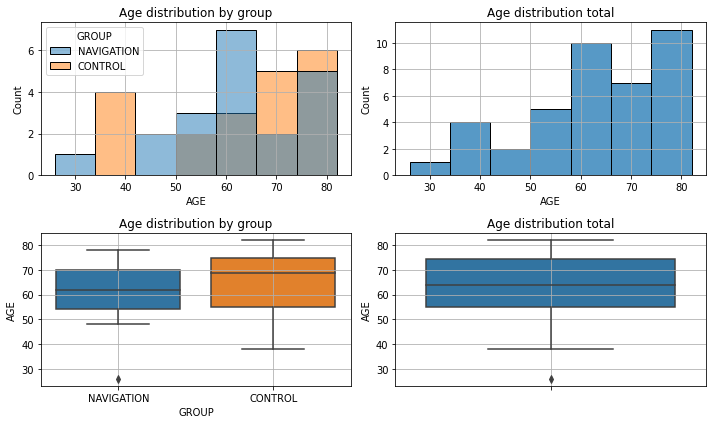

In [3]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 6))

sns.histplot(data[['AGE', 'GROUP']], x="AGE", hue="GROUP", ax=ax[0, 0])
ax[0, 0].set_title('Age distribution by group')
ax[0, 0].grid()

sns.histplot(data['AGE'], ax=ax[0, 1])
ax[0, 1].set_title('Age distribution total')
ax[0, 1].grid()


sns.boxplot(data=data[['AGE', 'GROUP']], x='GROUP', y='AGE', ax=ax[1, 0])
ax[1, 0].grid()
ax[1, 0].set_title('Age distribution by group')

sns.boxplot(y=data['AGE'], ax=ax[1, 1])
ax[1, 1].grid()
ax[1, 1].set_title('Age distribution total')

fig.tight_layout()

plt.savefig((PATH_IMG / 'age_plot.png'))

In [4]:
data[['AGE', 'GROUP']].groupby('GROUP').describe()

AGE                                                 
           count   mean        std   min   25%   50%    75%   max
GROUP                                                            
CONTROL     20.0  63.70  14.861111  38.0  55.0  68.5  74.75  82.0
NAVIGATION  20.0  61.15  12.658573  26.0  54.0  62.0  69.75  78.0

#### 2.2. SURGERY RESULTS

In [5]:
data[['FREE', 'NEAR', 'AFFECTED', 'GROUP']].groupby('GROUP').sum()

,FREE,NEAR,AFFECTED
GROUP,,,
CONTROL,90,2,28
NAVIGATION,105,4,11


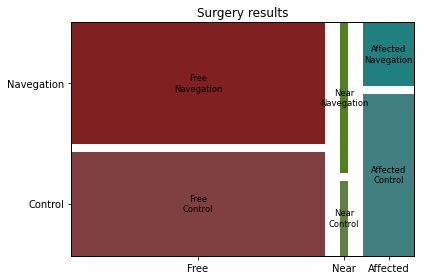

In [6]:
data_dict = {
    ('Free', 'Control'): 90, 
    ('Free', 'Navegation'): 105, 
    ('Near', 'Control'): 2, 
    ('Near', 'Navegation'): 4,
    ('Affected', 'Control'): 28,
    ('Affected', 'Navegation'): 11
}

mosaic(data_dict, gap=0.05, title='Surgery results', )
plt.tight_layout()
plt.savefig((PATH_IMG / 'mosaic_plot.png'))

Near and affected margins

In [7]:
margins = data[['SUPERIOR', 'INFERIOR', 'MEDIAL', 'LATERAL', 'SUPERFICIAL', 'DEEP']].copy()
margins = (margins!=0) * 1
margins['GROUP'] = data['GROUP'].copy()

margin_counts = margins.groupby('GROUP').sum().T
margin_counts.columns = ['Control', 'Navegation']
margin_counts['Total'] = margin_counts.sum(axis=1)

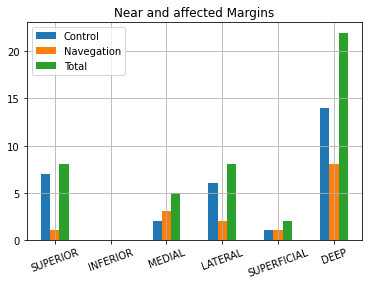

In [8]:
margin_counts.plot(kind='bar')
plt.grid()
plt.title('Near and affected Margins')
plt.xticks(rotation=20)
plt.savefig((PATH_IMG / 'margenes.png'))

#### 2.3 BROWN LEVELS

In [9]:
_index = ['IIB', 'IID', 'IIIB', 'IIID', 'IVB', 'IVD', 'V', 'VI']

In [10]:
data_brown = data[['GROUP', 'AFFECTED', 'RESECCION']].copy()
data_brown['counts'] = 1

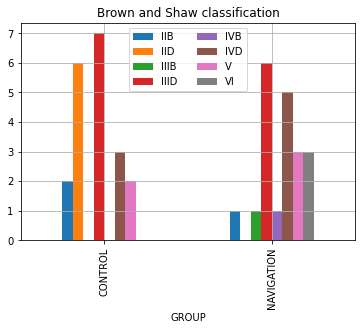

In [11]:
data_brown[['GROUP', 'RESECCION', 'counts']].groupby(['GROUP', 'RESECCION']).sum().unstack().plot(kind='bar')

plt.legend(_index, ncol=2)
plt.grid()
plt.title('Brown and Shaw classification')
plt.savefig((PATH_IMG /'Brown_by_group.png'))

In [12]:
new_brown = pd.DataFrame()
new_brown['Brown level counts'] = data_brown['RESECCION'].value_counts().sort_index()
new_brown['Affected by Brown level'] = data_brown.drop('GROUP', axis=1).groupby('RESECCION').sum()['AFFECTED']
new_brown.index = _index
new_brown

,Brown level counts,Affected by Brown level
IIB,3,4
IID,6,5
IIIB,1,0
IIID,13,18
IVB,1,0
IVD,8,6
V,5,4
VI,3,2


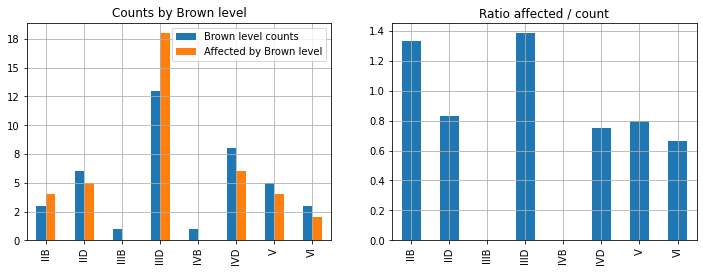

In [13]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

new_brown.plot(kind='bar', ax=ax[0])
ax[0].grid()
ax[0].set_title('Counts by Brown level')
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

(new_brown['Affected by Brown level'] / new_brown['Brown level counts']).plot(kind='bar', ax=ax[1])
ax[1].grid()
ax[1].set_title('Ratio affected / count')


plt.savefig((PATH_IMG /'brown_counts.png'))

#### 2.4 RECONSTRUCTION LEVELS

In [14]:
_index = ['Temporal', 'ALT', 'Recto abdominal', 'Dorsoescapular', 'Perone', 'Cresta Ilíaca']

In [15]:
rec_total = (data['RECONSTRUCTION'].value_counts() / len(data)).to_frame()
rec_control = (data['RECONSTRUCTION'][data['GROUP']=='CONTROL'].value_counts()/ len(data)).to_frame()
rec_nav = (data['RECONSTRUCTION'][data['GROUP']=='NAVIGATION'].value_counts()/ len(data)).to_frame()

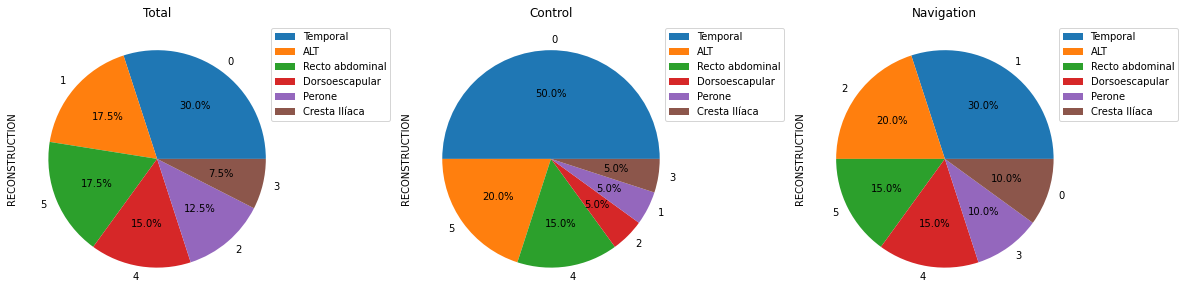

In [16]:
fig, ax = plt.subplots(figsize=(20, 5), ncols=3)

rec_total.plot.pie(y='RECONSTRUCTION', ax=ax[0], autopct='%1.1f%%')
ax[0].set_title('Total')
ax[0].legend(_index, bbox_to_anchor=(0.9, 1))

rec_control.plot.pie(y='RECONSTRUCTION', ax=ax[1], autopct='%1.1f%%')
ax[1].set_title('Control')
ax[1].legend(_index, bbox_to_anchor=(0.9, 1))

rec_nav.plot.pie(y='RECONSTRUCTION', ax=ax[2], autopct='%1.1f%%')
ax[2].set_title('Navigation')
ax[2].legend(_index, bbox_to_anchor=(0.9, 1))

plt.savefig((PATH_IMG / 'reconstruction.png'))

#### 2.5 SEX DATA

In [17]:
sex_df = data[['SEX', 'GROUP']].copy()
sex_df['GENDER'] = np.where(sex_df['SEX']==0, 'MALE', 'FEMALE')
sex_df = sex_df.drop('SEX', axis=1).groupby(['GROUP', 'GENDER']).value_counts()

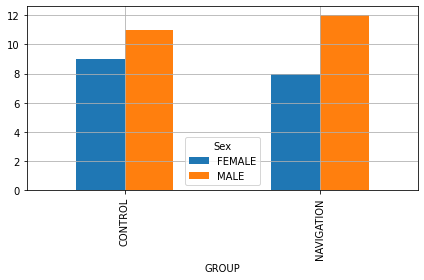

In [18]:
sex_df.to_frame().unstack().plot(kind='bar')
plt.grid()
plt.tight_layout()
plt.legend(['FEMALE', 'MALE'], title='Sex')
plt.savefig((PATH_IMG / 'gender_plot.png'))

#### 2.6 AP

In [19]:
_index = ['Squamous Cell Carcinoma', 'Adenocarcinoma', 'Sarcoma', 'Others']

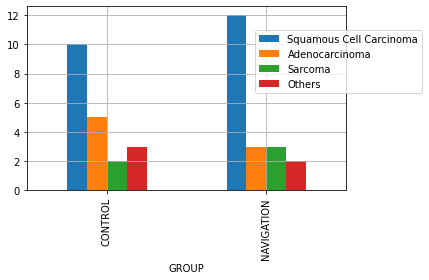

In [20]:
ap = data[['GROUP', 'AP']].copy()
ap['counts'] = 1

ap = ap.groupby(['GROUP', 'AP']).sum().unstack()

ap.plot(kind='bar')
plt.grid()
plt.legend(_index, bbox_to_anchor=(0.7, 0.5))
plt.tight_layout()
plt.savefig((PATH_IMG / 'ap_plot.png'))

#### 2.7 PRIMARIO RECIDIVA

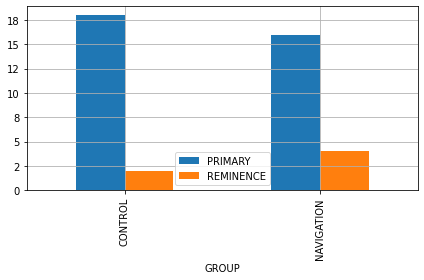

In [21]:
primario = data[['GROUP', 'PRIMARY_REMINENCE']].groupby(['GROUP']).value_counts()
ax = primario.to_frame().unstack().plot(kind='bar')
ax.grid()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.tight_layout()
ax.legend(['PRIMARY', 'REMINENCE'], title=None)
plt.savefig((PATH_IMG / 'prim_plot.png'))

#### 2.8 QT-RT

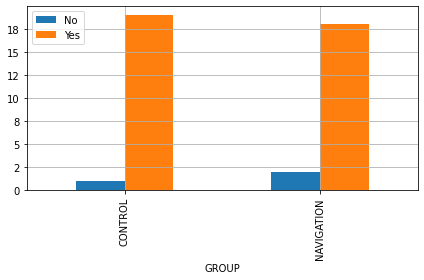

In [22]:
qtrt = data[['GROUP', 'QT-RT_ADYUV']].groupby(['GROUP']).value_counts()
ax = qtrt.to_frame().unstack().plot(kind='bar')
ax.grid()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.tight_layout()
ax.legend(['No', 'Yes'], title=None)
plt.savefig((PATH_IMG / 'qt_rt_plot.png'))

#### 2.9 LOCALIZATION

In [23]:
localizacion = pd.read_csv((PATH_DATA / 'localizacion.csv'), sep=";")

localizacion = localizacion.fillna(0)

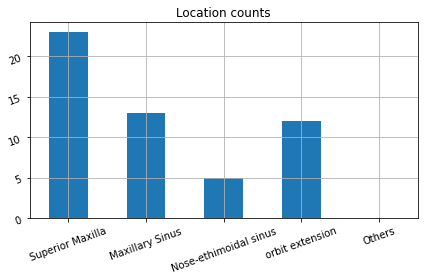

In [24]:
localizacion.drop('GROUP', axis=1).sum().plot(kind='bar')
plt.tick_params(rotation=20)
plt.grid()
plt.title('Location counts')
plt.tight_layout()
plt.savefig((PATH_IMG / 'loc_total.png'))

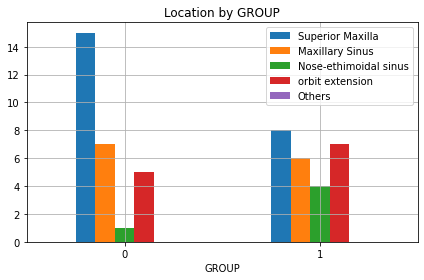

In [25]:
localizacion.groupby('GROUP').sum().plot(kind='bar')
plt.tick_params(rotation=0)
plt.grid()
plt.title('Location by GROUP')
plt.tight_layout()
plt.savefig((PATH_IMG / 'loc_group.png'))